## Import Libraries

In [14]:
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg 
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog


In [15]:
import json
import os
import sys
import random 
import PIL
import matplotlib.pyplot as plt 
import cv2
import numpy as np

## Global Variables

In [16]:
ROOT = os.path.abspath('../')
DATA_FOLDER = 'data/plates_with_json'
CONFIG = 'config'
WEIGHTS = 'weights'
DEVICE = 'cpu'

## Helper Functions 

In [17]:
def read_json(file_name, path):
    file_path = os.path.join(ROOT, path,file_name)
    try:
        with open(file_path) as annotations:
            data = json.load(annotations)
    except:
        print("LOG: Not file found")
    return data

def show_images():
    path = os.path.join(ROOT, DATA_FOLDER)
    annotations = read_json('dataset_mask_full_no_aug.json',DATA_FOLDER)
    files = annotations['_via_img_metadata']
    row,col = 2,2
    for num, x in enumerate(files):
        if num == row*col:
            break
        img = PIL.Image.open(os.path.join(path, files[x]['filename']))
        plt.subplot(row,col,num+1)
        plt.title(x.split('.')[0])
        plt.axis('off')
        plt.imshow(img)

def show_images_with_bb():
    annotations = read_json('dataset_mask_full_no_aug.json',DATA_FOLDER)
    files = annotations['_via_img_metadata']
    for d in random.sample(list(files.values()), 3):
        img = cv2.imread(os.path.join(ROOT,DATA_FOLDER,d["filename"]))
        print(img)
        visualizer = Visualizer(img[:, :, ::-1], metadata=data, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        cv2_imshow(vis.get_image()[:, :, ::-1])

In [18]:
def get_carplate_dicts():
    path = os.path.join(ROOT, DATA_FOLDER)
    json_file = os.path.join(path, "dataset_mask_full_no_aug.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    dataset_dicts = []
    for idx, v in enumerate(list(imgs_anns['_via_img_metadata'].values())):
        record = {}
        
        filename = os.path.join(path, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for anno in annos:
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

## Prepare Dataset

In [19]:
dataset_dicts = get_carplate_dicts()

In [20]:

DatasetCatalog.register("carplate", lambda : get_carplate_dicts())
MetadataCatalog.get("carplate").set(thing_classes=["carplate"])
carplate_metadata = MetadataCatalog.get("carplate_train")

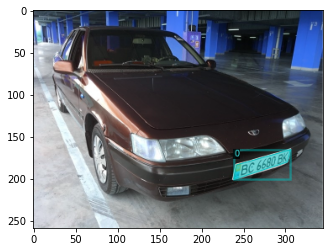

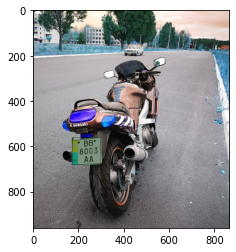

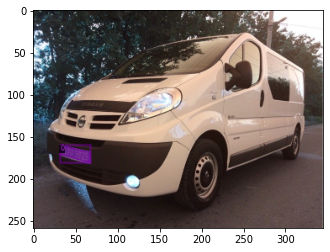

In [21]:

for d in random.sample(dataset_dicts, 3):
    window_name = 'image'
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=carplate_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

## Train Model

In [22]:
cfg = get_cfg()
cfg.merge_from_file(os.path.join(ROOT, CONFIG, "mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("carplate",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.DEVICE = DEVICE
cfg.MODEL.WEIGHTS = os.path.join(ROOT,WEIGHTS,"R-50.pkl")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)


In [26]:

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()

[05/17 07:39:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[05/17 07:40:14 d2.data.build]: Removed 0 images with no usable annotations. 1867 images left.
[05/17 07:40:14 d2.data.common]: Serializing 1867 elements to byte tensors and concatenating them all ...
[05/17 07:40:14 d2.data.common]: Serialized dataset takes 0.99 MiB
[05/17 07:40:14 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[05/17 07:40:14 d2.data.build]: Using training sampler TrainingSampler


## Inference 

In [23]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("carplate", )
predictor = DefaultPredictor(cfg)

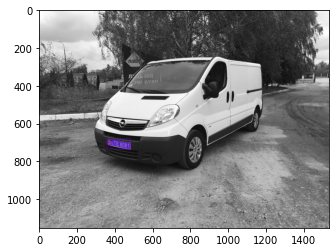

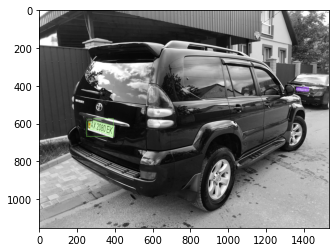

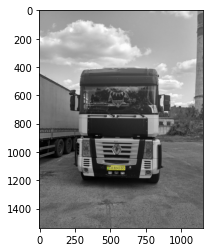

In [24]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_carplate_dicts()
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=carplate_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to(DEVICE))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()

In [27]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("carplate", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "carplate")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[05/17 07:41:06 d2.data.common]: Serializing 1867 elements to byte tensors and concatenating them all ...
[05/17 07:41:06 d2.data.common]: Serialized dataset takes 0.99 MiB
[05/17 07:41:06 d2.evaluation.evaluator]: Start inference on 1867 images
[05/17 07:41:17 d2.evaluation.evaluator]: Inference done 1/1867. 9.9423 s / img. ETA=5:27:35
[05/17 07:41:25 d2.evaluation.evaluator]: Inference done 2/1867. 8.8538 s / img. ETA=4:48:34
[05/17 07:41:33 d2.evaluation.evaluator]: Inference done 3/1867. 8.4778 s / img. ETA=4:34:49
[05/17 07:41:41 d2.evaluation.evaluator]: Inference done 4/1867. 8.3616 s / img. ETA=4:30:06
[05/17 07:41:50 d2.evaluation.evaluator]: Inference done 5/1867. 8.3053 s / img. ETA=4:27:36
[05/17 07:41:58 d2.evaluation.evaluator]: Inference done 6/1867. 7.8618 s / img. ETA=4:11:03


KeyboardInterrupt: 